# DATA HARVESTER NOTEBOOK
-------------------------

The Data Harvester enables researchers with reusable workflows for automatic data extraction from a range of data sources including spatial-temporal processing into useable formats. User provided data is auto-completed with a suitable set of spatial- and temporal-aligned covariates as a ready-made dataset for machine learning and agriculture models. In addition, all requested data layer maps are automatically extracted and aligned for a specific region and time period. 

The main workflow of the Harvester is as follows: 
1) Options and user settings (e.g., data layer selections, spatial coverage, temporal constraints, i/o directory names) are defined by the user in the notebook settings menu or can be loaded with a settings yaml file (e.g., settings/settings_v0.2_saved.yaml). All settings are also saved in a yaml file for reusability.
2) The notebook imports settings and all Python modules that include functionality to download and extract data for each data source. After settings are read in, checked, and processed into valid data retrieval (API) queries, all selected data layers are sequentially downloaded and then processed into a clean dataframe table and co-registered raster maps. The entire workflow can be run either completely automatically or individually by selecting only certain process parts in the Notebook.

Additional data sources can be best added by writing the API handlers and extraction functionalities as separate Python module, which are then imported by the Notebook. Currently the following data sources are supported by the following modules:

- 'getdata_slga.py': Soil Data from Soil and Landscape Grid of Australia (SLGA)
- 'getdata_landscape': Landscape data from Soil and Landscape Grid of Australia (SLGA)
- 'getdata_silo.py': Climate Data from SILO
- 'getdata_dem.py: 'National Digital Elevation Model (DEM) 1 Second plus Slope and Apect calculation
- 'getdata_dea_nci.py: 'Digital Earth Australia's (DEA) Geoscience Earth Observations via NCI server
- 'getdata_dea.py: 'Digital Earth Australia's (DEA) Geoscience Earth Observations via Open Web Service server provided by DEA
- 'getdata_radiometric.py': Geoscience Australia National Geophysical Compilation Sub-collection Radiometrics

For more details. please see README and the Data Overview page.

This notebook is part of the Data Harvester project developed for the Agricultural Research Federation (AgReFed).

Copyright 2022 Sydney Informatics Hub (SIH), The University of Sydney

In [1]:
#Load general python libraries
import geopandas as gpd
import pandas as pd
import os
from os.path import exists
import time
from datetime import datetime
from types import SimpleNamespace 
import matplotlib.pyplot as plt
from pathlib import Path

# Load local modules/functions/packages
# See each python file for detailed options
import getdata_silo 
import getdata_slga 
import getdata_dea
import getdata_dem
import getdata_radiometric
import getdata_landscape
import utils
from utils import init_logtable, update_logtable
from arc2meter import calc_arc2meter

In [ ]:
# This cell is tagged with "parameters" if notebook is run with papermill command line arguments (leave blank)
load_settingsfilename = ''

### Initialize Settings Display

In [2]:
#NEW: For importing custom settings widgets
from widgets import harvesterwidgets as hw
tab_nest, w_settings, names_settings, w_load = hw.gen_maintab()
display(tab_nest) 
#Note: the display screen may take a couple of seconds more after loading
time.sleep(8)

## Import settings

Let's start with loading all user settings and options as specified in the settings file. For this example we provide a template file `settings/settings_v0.1_default.yaml`. You can comfortable use the default settings in this file. 
Or you may changed the file directly, or point to a new file.
Or override any of the defaults throughout this notebook.

In [37]:
#For recording time:
start_time = datetime.now()

if load_settingsfilename != '':
    # load settings fromm file given by command line argument
    print(f'Automatinc loading settings from {load_settingsfilename}')
    settings = hw.load_settings(load_settingsfilename)
elif w_load.value == None:
    # if no settings file selected, convert widgets inputs above to settings
    dict_settings = hw.eval_widgets(w_settings, names_settings)
    # Convert settings from dictionary to SimpleNamespace (so all settings names available as settings.xxxname)
    settings = SimpleNamespace(**dict_settings)
    # Check if output path exists, if not create it:
    os.makedirs(settings.outpath, exist_ok=True) 
    # Save settings to yaml file:
    hw.save_dict_settings(dict_settings, os.path.join(settings.outpath, 'settings_saved.yaml'))
else:
    print(f'Settings loaded from {w_load.value}')
    settings = hw.load_settings(w_load.value)
hw.print_settings(settings)


Settings saved to file ../dataresults_testnotebook/settings_saved.yaml
Settings loaded:
----------------
settings.infile : /Users/seb/CTDS/Projects/AgReFed/Harvester/code/AgReFed-DataHarvester/testdata/Pointdata_Llara.csv
settings.outpath : ../dataresults_testnotebook/
settings.colname_lng : Long
settings.colname_lat : Lat
settings.target_bbox : 
settings.target_res : 12.0
settings.target_dates : (2021,)
settings.temp_res : 365
settings.target_sources:
   'SLGA': {'Bulk_Density': ['0-5cm']}
   'SILO': {'monthly_rain': ['Total']}
   'DEA': ['landsat_barest_earth']
   'DEM': ['DEM', 'Slope', 'Aspect']
   'Radiometric': ['radmap2019_grid_dose_terr_filtered_awags_rad_2019']
   'Landscape': ['Relief_300m']


## Setup dataset of interest

Here we are reading in the point locations for which we want to extract data. A custom bounding box for which to extract raster data can be set in the settings file. If no bounding box provided, rasters are extracted for the region given by the point location extent plus an additional padding of 0.05 deg in Lat/Long (see code below).

In [38]:
# Load in the dataset defining our location of interest as a geopandas dataframe
gdfpoints = gpd.read_file(settings.infile)

# This particular dataset contains duplicate point locations at different depths.
# We can take advantage of the Notebook environment to make small manipulations
# to pull out just the data we need, i.e:
gdfpoints=gdfpoints.loc[gdfpoints['depth'] == "0-5 cm"]

# Assing the data to well-named variables
longs = gdfpoints[settings.colname_lng].astype(float)
lats = gdfpoints[settings.colname_lat].astype(float)

In [39]:
# Check the data looks reasonable
gdfpoints.head()

,field_1,Lat,Long,Easting,Northing,depth,geometry
0,0,-30.264663,149.85268,774457.572546495,6648441.94497259,0-5 cm,None
5,5,-30.265302,149.884838,777550.996253435,6648292.91822913,0-5 cm,None
9,9,-30.265302,149.884838,777550.996253435,6648292.91822913,0-5 cm,None
14,14,-30.278542,149.838791,773082.294868699,6646936.5315563,0-5 cm,None
19,19,-30.275437,149.830843,772325.998393026,6647299.91001948,0-5 cm,None


In [14]:
# Use padding area of interest +/- 0.05 deg if no bbox provided. 
if (settings.target_bbox == None) | (settings.target_bbox == 'None') | (settings.target_bbox == ''):
    settings.target_bbox = (min(longs)-0.05,min(lats)-0.05,max(longs)+0.05,max(lats)+0.05)
print(f'Info: Selected bounding box: {settings.target_bbox}')

# Estimate resolution in meters:
lat_center = (settings.target_bbox[1]+settings.target_bbox[3])/2
xres_meters, yres_meters = calc_arc2meter(settings.target_res, lat_center)
print(f'Info: {settings.target_res} arcsec resolution corresponds to {xres_meters:.1f}m x {yres_meters:.1f}m in x,y direction respectively (at Latitude: {lat_center:.2f}).')

Info: Selected bounding box: (149.769345, -30.335861, 149.949173, -30.206271)
Info: 6.0 arcsec resolution corresponds to 160.2m x 185.2m in x,y direction respectively (at Latitude: -30.27).


## Download and process data from API sources

From here we automatically download and process sequentially a range of data sources as specified in the settings file (see next subsections: SLGA, SILO, DEA, DEM). Note that you may retrieve info and parameter input options for any function easily by running a function/method with a preceeding '?', e.g:
```
?getdata_slga.get_slga_layers
?utils
```

In [15]:
# Initiate a dataframe for logging all data output names and layer titles.
# Note that the log table is later updated with update_logtable(), which also instantly saves a copy of the table of the current status.
df_log = init_logtable()

### SLGA Download

Here we download all requested data layers from the Soil and Landscape Grid of Australia (SLGA) for the given bounding box. Note that for this example we select the top soil (0 - 5cm) only. Optionally other layers and depths including confidence intervals can be extracted as well; for more details and options see getdata_slga.py.

In [16]:
# We can set the input options for each function call, and additional parameters may be set
# too. Check the documentation of each function for full list of options.
depth_min, depth_max = getdata_slga.identifier2depthbounds(list(settings.target_sources['SLGA'].values())[0])
slga_layernames = list(settings.target_sources['SLGA'].keys())
fnames_out_slga = getdata_slga.get_slga_layers(
    slga_layernames, 
    settings.target_bbox, 
    settings.outpath, 
    depth_min = depth_min, 
    depth_max= depth_max, 
    get_ci = True)

SLGA_Bulk_Density_0-5cm downloaded. Saved to:  ../../dataresults/SLGA_Bulk_Density_0-5cm.tif
SLGA_Bulk_Density_0-5cm CIs downloaded.
../../dataresults/SLGA_Clay_0-5cm.tif already exists
SLGA_Clay_0-5cm downloaded. Saved to:  ../../dataresults/SLGA_Clay_0-5cm.tif
../../dataresults/SLGA_Clay_0-5cm_5percentile.tif already exists
../../dataresults/SLGA_Clay_0-5cm_95percentile.tif already exists
SLGA_Clay_0-5cm CIs downloaded.
SLGA Download complete.


In [17]:
# Add download info to log dataframe
df_log = update_logtable(df_log, fnames_out_slga, slga_layernames, 'SLGA', settings, layertitles = [], loginfos = 'downloaded')
df_log

,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded


### SILO Download

Here we download climate data layers from SILO and extract raster for the given bounding box and year.
For more details see getdata_silo.py

In [18]:
# Each data-source must be handled differently (as the data is stored in different ways)
# Here we must get each layer, one by one. The simplest way is to loop through them.
# Get data for each layer
fnames_out_silo = []
silo_layernames = list(settings.target_sources['SILO'].keys())
for layername in silo_layernames:
    # define output file name
    outpath = settings.outpath+'mvp_'+layername+'_silo'
    # run the download
    fnames_out = getdata_silo.get_SILO_raster(
        layername, 
        settings.target_dates, 
        outpath, 
        bbox = settings.target_bbox, 
        format_out = 'tif', 
        delete_temp= False)
    #Save the layer name
    fnames_out_silo += fnames_out

# Add download info to log dataframe
df_log = update_logtable(df_log, fnames_out_silo, silo_layernames, 'SILO', settings, layertitles = [], loginfos = 'downloaded')
df_log

../../dataresults/mvp_monthly_rain_silo/2021.monthly_rain.nc already exists
Saved monthly_rain for year 2021 as geotif: 
../../dataresults/mvp_monthly_rain_silo/monthly_rain_2021_cropped.tif
../../dataresults/mvp_max_temp_silo/2021.max_temp.nc already exists
Saved max_temp for year 2021 as geotif: 
../../dataresults/mvp_max_temp_silo/max_temp_2021_cropped.tif
../../dataresults/mvp_min_temp_silo/2021.min_temp.nc already exists
Saved min_temp for year 2021 as geotif: 
../../dataresults/mvp_min_temp_silo/min_temp_2021_cropped.tif


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded
2,monthly_rain,Total,SILO,monthly_rain_Total,../../dataresults/mvp_monthly_rain_silo/monthl...,downloaded
3,max_temp,Median,SILO,max_temp_Median,../../dataresults/mvp_max_temp_silo/max_temp_2...,downloaded
4,min_temp,Median,SILO,min_temp_Median,../../dataresults/mvp_min_temp_silo/min_temp_2...,downloaded


#### SILO Processing

This is an example for further processing of the extracted SILO data. Here we are interested in generating a mean temperature raster given the already extracted min and max temperature rasters.

In [19]:
#Gere we want to immediately perform some data processing on the SILO layers.

# Sub select whatever files we want to aggregate, from the log file
file_list = df_log[df_log['layername'].isin(['min_temp','max_temp'])].filename_out.to_list()

if len(file_list) == 2:
    # Both have a recommendation of running mean, so lets set that
    agg = ['mean']

    # Set an output filename if wanted
    outfile = settings.outpath+'silo_temp_2019_ag'

    # And run the processing
    outfname_agg = utils.aggregate_rasters(
        file_list=file_list,
        outfile=outfile, 
        data_dir=None,
        agg=agg)
        
    # Add processed info to log dataframe
    df_log = update_logtable(df_log, [outfname_agg[0]], ['mean_temp'], 'SILO', settings, layertitles = ['mean_temp'], agfunctions = ['mean'], loginfos = 'processed')
    df_log

Finding ['mean']  out of possible ['mean', 'median', 'sum', 'perc95', 'perc5']
mean of filelist saved in:  ../../dataresults/silo_temp_2019_ag_mean.tif


### DEA Download

Here we download satellite data from Digital Earth Australia (DEA) within the given bounding box and for all available image capture dates that are available within the specified year(s). For more details see getdata_dea.py or getdata_dea_nci
.py

In [23]:
dea_layernames = settings.target_sources['DEA']

# These are multiple files, so we put them in a subdirectory to make subsequent processing easier.
outpath_dea = os.path.join(settings.outpath,'mvp_dea')

outfnames = getdata_dea.get_dea_layers(
    dea_layernames, 
    settings.target_dates, 
    settings.target_bbox, 
    settings.target_res, 
    outpath_dea, 
    crs = 'EPSG:4326', 
    format_out = 'GeoTIFF')


Number of images for 2021 found: 0
No dates found for year 2021. Trying to download without date.
landsat_barest_earth for date None downloaded
All layers downloads completed and saved in directory ../../dataresults/mvp_dea.


#### DEA Processing

This aggregates all images for the given year(s) and gnerates a combined image, here for example for the mean and 5th and 95th percentile each.

In [24]:
# Process DEA data over time aggregates
outfname_list, channel_list, agg_list = utils.aggregate_multiband(
    data_dir = outpath_dea,
    outfile = settings.outpath+"mvp_dea",
    agg = ['mean','perc95','perc5'],
    file_list = None)

Finding ['mean', 'perc95', 'perc5']  out of possible ['mean', 'median', 'sum', 'perc95', 'perc5']
Reading all *.tif files in:  ../../dataresults/mvp_dea
mean of filelist saved in:  ../../dataresults/mvp_dea_mean_channel_0.tif
perc95 of filelist saved in:  ../../dataresults/mvp_dea_perc95_channel_0.tif
perc5 of filelist saved in:  ../../dataresults/mvp_dea_perc5_channel_0.tif
mean of filelist saved in:  ../../dataresults/mvp_dea_mean_channel_1.tif
perc95 of filelist saved in:  ../../dataresults/mvp_dea_perc95_channel_1.tif
perc5 of filelist saved in:  ../../dataresults/mvp_dea_perc5_channel_1.tif
mean of filelist saved in:  ../../dataresults/mvp_dea_mean_channel_2.tif
perc95 of filelist saved in:  ../../dataresults/mvp_dea_perc95_channel_2.tif
perc5 of filelist saved in:  ../../dataresults/mvp_dea_perc5_channel_2.tif


In [25]:
# Add extracted data info to log table
layernames = [layername + '_channel' + channel_list[i] for i in range(len(channel_list))]
df_log = update_logtable(df_log, outfname_list, layernames, 'DEA', settings, agfunctions = agg_list, loginfos = 'processed')
#print(df_log.layertitle)
df_log

,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded
2,monthly_rain,Total,SILO,monthly_rain_Total,../../dataresults/mvp_monthly_rain_silo/monthl...,downloaded
3,max_temp,Median,SILO,max_temp_Median,../../dataresults/mvp_max_temp_silo/max_temp_2...,downloaded
4,min_temp,Median,SILO,min_temp_Median,../../dataresults/mvp_min_temp_silo/min_temp_2...,downloaded
5,mean_temp,mean,SILO,mean_temp,../../dataresults/silo_temp_2019_ag_mean.tif,processed
6,min_temp_channel0,mean,DEA,min_temp_channel0_mean,../../dataresults/mvp_dea_mean_channel_0.tif,processed
7,min_temp_channel0,perc95,DEA,min_temp_channel0_perc95,../../dataresults/mvp_dea_perc95_channel_0.tif,processed
8,min_temp_channel0,perc5,DEA,min_temp_channel0_perc5,../../dataresults/mvp_dea_perc5_channel_0.tif,processed
9,min_temp_channel1,mean,DEA,min_temp_channel1_mean,../../dataresults/mvp_dea_mean_channel_1.tif,processed


### DEM Download

Here we download and extract the National Digital Elevation Model (DEM), and also generate slope and aspect rasters from the extracted DEM. 
For more details see getdata_dem.py

In [26]:
outpath = os.path.join(settings.outpath, "mvp_dem")
dem_layernames = settings.target_sources['DEM']
outfnames = getdata_dem.get_dem_layers(dem_layernames, outpath, settings.target_bbox, settings.target_res)

# Add extracted data to log dataframe
df_log = update_logtable(
    df_log, outfnames, 
    dem_layernames, 
    'DEM', 
    settings, 
    layertitles = dem_layernames,
    loginfos = 'downloaded')
df_log

DEM downloaded to: ../../dataresults/mvp_dem/DEM_SRTM_1_Second_Hydro_Enforced_2022-07-04.tif
DEM slope from: ../../dataresults/mvp_dem/DEM_SRTM_1_Second_Hydro_Enforced_2022-07-04.tif  saved to: ../../dataresults/mvp_dem/Slope_DEM_SRTM_1_Second_Hydro_Enforced_2022-07-04.tif
DEM aspect from: ../../dataresults/mvp_dem/DEM_SRTM_1_Second_Hydro_Enforced_2022-07-04.tif  saved to: ../../dataresults/mvp_dem/Aspect_DEM_SRTM_1_Second_Hydro_Enforced_2022-07-04.tif


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded
2,monthly_rain,Total,SILO,monthly_rain_Total,../../dataresults/mvp_monthly_rain_silo/monthl...,downloaded
3,max_temp,Median,SILO,max_temp_Median,../../dataresults/mvp_max_temp_silo/max_temp_2...,downloaded
4,min_temp,Median,SILO,min_temp_Median,../../dataresults/mvp_min_temp_silo/min_temp_2...,downloaded
5,mean_temp,mean,SILO,mean_temp,../../dataresults/silo_temp_2019_ag_mean.tif,processed
6,min_temp_channel0,mean,DEA,min_temp_channel0_mean,../../dataresults/mvp_dea_mean_channel_0.tif,processed
7,min_temp_channel0,perc95,DEA,min_temp_channel0_perc95,../../dataresults/mvp_dea_perc95_channel_0.tif,processed
8,min_temp_channel0,perc5,DEA,min_temp_channel0_perc5,../../dataresults/mvp_dea_perc5_channel_0.tif,processed
9,min_temp_channel1,mean,DEA,min_temp_channel1_mean,../../dataresults/mvp_dea_mean_channel_1.tif,processed


### Landscape

Download landscape data from Soil and Landscape Grid of Australia (SLGA).

In [27]:
# Download landscape data
layernames = settings.target_sources['Landscape']
layertitles = ['Landscape_' + layername for layername in layernames]

outfnames = getdata_landscape.get_landscape_layers(
    layernames, 
    settings.target_bbox, 
    settings.outpath, 
    resolution = settings.target_res)

# Add extracted data to log dataframe
df_log = update_logtable(
    df_log, outfnames, 
    layernames, 
    'Landscape', 
    settings, 
    layertitles = layertitles,
    loginfos = 'downloaded')
df_log


Slope downloaded. Saved to:  ../../dataresults/Landscape_Slope.tif
Aspect downloaded. Saved to:  ../../dataresults/Landscape_Aspect.tif
Relief_300m downloaded. Saved to:  ../../dataresults/Landscape_Relief_300m.tif
Landscape Download complete.


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded
2,monthly_rain,Total,SILO,monthly_rain_Total,../../dataresults/mvp_monthly_rain_silo/monthl...,downloaded
3,max_temp,Median,SILO,max_temp_Median,../../dataresults/mvp_max_temp_silo/max_temp_2...,downloaded
4,min_temp,Median,SILO,min_temp_Median,../../dataresults/mvp_min_temp_silo/min_temp_2...,downloaded
5,mean_temp,mean,SILO,mean_temp,../../dataresults/silo_temp_2019_ag_mean.tif,processed
6,min_temp_channel0,mean,DEA,min_temp_channel0_mean,../../dataresults/mvp_dea_mean_channel_0.tif,processed
7,min_temp_channel0,perc95,DEA,min_temp_channel0_perc95,../../dataresults/mvp_dea_perc95_channel_0.tif,processed
8,min_temp_channel0,perc5,DEA,min_temp_channel0_perc5,../../dataresults/mvp_dea_perc5_channel_0.tif,processed
9,min_temp_channel1,mean,DEA,min_temp_channel1_mean,../../dataresults/mvp_dea_mean_channel_1.tif,processed


### Radiometrics

Download maps of Geoscience Australia National Geophysical Compilation Sub-collection Radiometrics

In [28]:
# Download radiometrics
layernames = settings.target_sources['Radiometric']

outfnames = getdata_radiometric.get_radiometric_layers(
    settings.outpath, 
    layernames, 
    bbox = settings.target_bbox, 
    resolution=settings.target_res)

 # Add extracted data to log dataframe
df_log = update_logtable(
    df_log, outfnames, 
    layernames, 
    'Radiometric', 
    settings, 
    layertitles = layernames,
    loginfos = 'downloaded')
df_log

Layer radmap2019_grid_dose_terr_awags_rad_2019 saved in ../../dataresults/radiometric_radmap2019_grid_dose_terr_awags_rad_2019.tif
Layer radmap2019_grid_dose_terr_filtered_awags_rad_2019 saved in ../../dataresults/radiometric_radmap2019_grid_dose_terr_filtered_awags_rad_2019.tif


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded
2,monthly_rain,Total,SILO,monthly_rain_Total,../../dataresults/mvp_monthly_rain_silo/monthl...,downloaded
3,max_temp,Median,SILO,max_temp_Median,../../dataresults/mvp_max_temp_silo/max_temp_2...,downloaded
4,min_temp,Median,SILO,min_temp_Median,../../dataresults/mvp_min_temp_silo/min_temp_2...,downloaded
5,mean_temp,mean,SILO,mean_temp,../../dataresults/silo_temp_2019_ag_mean.tif,processed
6,min_temp_channel0,mean,DEA,min_temp_channel0_mean,../../dataresults/mvp_dea_mean_channel_0.tif,processed
7,min_temp_channel0,perc95,DEA,min_temp_channel0_perc95,../../dataresults/mvp_dea_perc95_channel_0.tif,processed
8,min_temp_channel0,perc5,DEA,min_temp_channel0_perc5,../../dataresults/mvp_dea_perc5_channel_0.tif,processed
9,min_temp_channel1,mean,DEA,min_temp_channel1_mean,../../dataresults/mvp_dea_mean_channel_1.tif,processed


## Save the final log or start from here to re-load it in.
We have now completed the data download section. You may add additional downlods and processing steps to your log file.

In [29]:
# Save out (or load in) the log file.
logfile = settings.outpath+'log.csv'
if exists(logfile):
    df_log = pd.read_csv(settings.outpath+'log.csv')
else:
    df_log.to_csv(settings.outpath+'log.csv',index=False)

df_log

,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,../../dataresults/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,../../dataresults/SLGA_Clay_0-5cm.tif,downloaded
2,monthly_rain,Total,SILO,monthly_rain_Total,../../dataresults/mvp_monthly_rain_silo/monthl...,downloaded
3,max_temp,Median,SILO,max_temp_Median,../../dataresults/mvp_max_temp_silo/max_temp_2...,downloaded
4,min_temp,Median,SILO,min_temp_Median,../../dataresults/mvp_min_temp_silo/min_temp_2...,downloaded
5,mean_temp,mean,SILO,mean_temp,../../dataresults/silo_temp_2019_ag_mean.tif,processed
6,min_temp_channel0,mean,DEA,min_temp_channel0_mean,../../dataresults/mvp_dea_mean_channel_0.tif,processed
7,min_temp_channel0,perc95,DEA,min_temp_channel0_perc95,../../dataresults/mvp_dea_perc95_channel_0.tif,processed
8,min_temp_channel0,perc5,DEA,min_temp_channel0_perc5,../../dataresults/mvp_dea_perc5_channel_0.tif,processed
9,min_temp_channel1,mean,DEA,min_temp_channel1_mean,../../dataresults/mvp_dea_mean_channel_1.tif,processed


## Points extraction from downloaded/processed data

By default point values of all processed layers in df_log are extracted given by the input locations. However, you can select also only certain layers (see in code). 

In [30]:
# Select all processed data
df_sel = df_log.copy()

# or select only the rasters of interest, for example:
"""
df_sel = df_log[df_log['layername'].isin(['DEM','Slope',
'landsat8_nbart_16day_channel0', 
'Organic_Carbon','Depth_of_Soil',
'mean_temp','monthly_rain'])]
"""

rasters= df_sel['filename_out'].values.tolist()
titles = df_sel['layertitle'].values.tolist()
    
# Extract datatable from rasters given input coordinates
gdf = utils.raster_query(longs,lats,rasters,titles)

Opening: ../../dataresults/SLGA_Bulk_Density_0-5cm.tif
Raster pixel size: (156, 216)
Opening: ../../dataresults/SLGA_Clay_0-5cm.tif
Raster pixel size: (156, 216)
Opening: ../../dataresults/mvp_monthly_rain_silo/monthly_rain_2021_cropped.tif
Raster pixel size: (2, 3)
Opening: ../../dataresults/mvp_max_temp_silo/max_temp_2021_cropped.tif
Raster pixel size: (2, 3)
Opening: ../../dataresults/mvp_min_temp_silo/min_temp_2021_cropped.tif
Raster pixel size: (2, 3)
Opening: ../../dataresults/silo_temp_2019_ag_mean.tif
Raster pixel size: (2, 3)
Opening: ../../dataresults/mvp_dea_mean_channel_0.tif
Raster pixel size: (77, 107)
Opening: ../../dataresults/mvp_dea_perc95_channel_0.tif
Raster pixel size: (77, 107)
Opening: ../../dataresults/mvp_dea_perc5_channel_0.tif
Raster pixel size: (77, 107)
Opening: ../../dataresults/mvp_dea_mean_channel_1.tif
Raster pixel size: (77, 107)
Opening: ../../dataresults/mvp_dea_perc95_channel_1.tif
Raster pixel size: (77, 107)
Opening: ../../dataresults/mvp_dea_perc

### Inspect result dataframe

In [31]:
# Inspect either entire generated dataframe with 
# gdf
# or only the first rows
gdf.head()

,Longitude,Latitude,geometry,Bulk_Density_0-5cm,Clay_0-5cm,monthly_rain_Total,max_temp_Median,min_temp_Median,mean_temp,min_temp_channel0_mean,...,min_temp_channel2_perc95,min_temp_channel2_perc5,DEM,Slope,Aspect,Landscape_Slope,Landscape_Aspect,Landscape_Relief_300m,radmap2019_grid_dose_terr_awags_rad_2019,radmap2019_grid_dose_terr_filtered_awags_rad_2019
0,149.852680,-30.264663,POINT (149.85268 -30.26466),1.368779,27.214527,47.000000,37.500000,24.700001,20.678619,1059.0,...,541.0,541.0,244.658585,89.899475,265.249023,1.046624,209.138062,10.463379,33.151680,32.962944
5,149.884838,-30.265302,POINT (149.88484 -30.26530),1.362662,31.956041,47.399902,37.299999,24.500000,20.548504,1082.0,...,540.0,540.0,264.428772,89.937111,291.358032,1.001000,279.542847,6.037811,35.969486,35.945480
9,149.884838,-30.265302,POINT (149.88484 -30.26530),1.362662,31.956041,47.399902,37.299999,24.500000,20.548504,1082.0,...,540.0,540.0,264.428772,89.937111,291.358032,1.001000,279.542847,6.037811,35.969486,35.945480
14,149.838791,-30.278542,POINT (149.83879 -30.27854),1.360451,32.675858,35.899902,37.600002,24.900000,20.803707,1092.0,...,601.0,601.0,233.005081,89.918648,250.619858,0.841430,242.743683,4.798782,29.618393,29.478428
19,149.830843,-30.275437,POINT (149.83084 -30.27544),1.334362,35.097813,35.899902,37.600002,24.900000,20.803707,1160.0,...,626.0,626.0,230.575439,89.921860,194.598907,1.062537,242.921112,5.204880,25.061012,24.757614


In [32]:
# Get some general info about result table:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 82 entries, 0 to 309
Data columns (total 26 columns):
 #   Column                                             Non-Null Count  Dtype   
---  ------                                             --------------  -----   
 0   Longitude                                          82 non-null     float64 
 1   Latitude                                           82 non-null     float64 
 2   geometry                                           82 non-null     geometry
 3   Bulk_Density_0-5cm                                 82 non-null     float32 
 4   Clay_0-5cm                                         82 non-null     float32 
 5   monthly_rain_Total                                 82 non-null     float32 
 6   max_temp_Median                                    82 non-null     float32 
 7   min_temp_Median                                    82 non-null     float32 
 8   mean_temp                                          82 non-null     float3

### Save the results table

Finally, the result dataframe table is saved as a csv file, which can be used now to do some awesome ML.
In addition the results are also saved as a geo-spatial referenced geopackage (.gpkg), which can be used again as input for further analysis or to inspect and overlay data on other layers and basemaps. The geopackage is a standard georeferenced file format and can be opened with any geo-spatial package or interactive software (e.g., QGIS, Esri ArcGIS). 

In [33]:
# Save the results table to a csv 
gdf.to_csv(os.path.join(settings.outpath, "results.csv"), index = True, mode='w')

# Save also as geopackage
gdf.to_file(os.path.join(settings.outpath, "results.gpkg"), driver="GPKG")
# Note: The deprecated warning below is a bug in geopandas and will be fixed in their bext version.

/Users/seb/mambaforge/envs/py39_agrefed/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Overview plot of all processed rasters 

This provides a quick overview to inspect all processed data layers with an overlay of the requested location points.
  

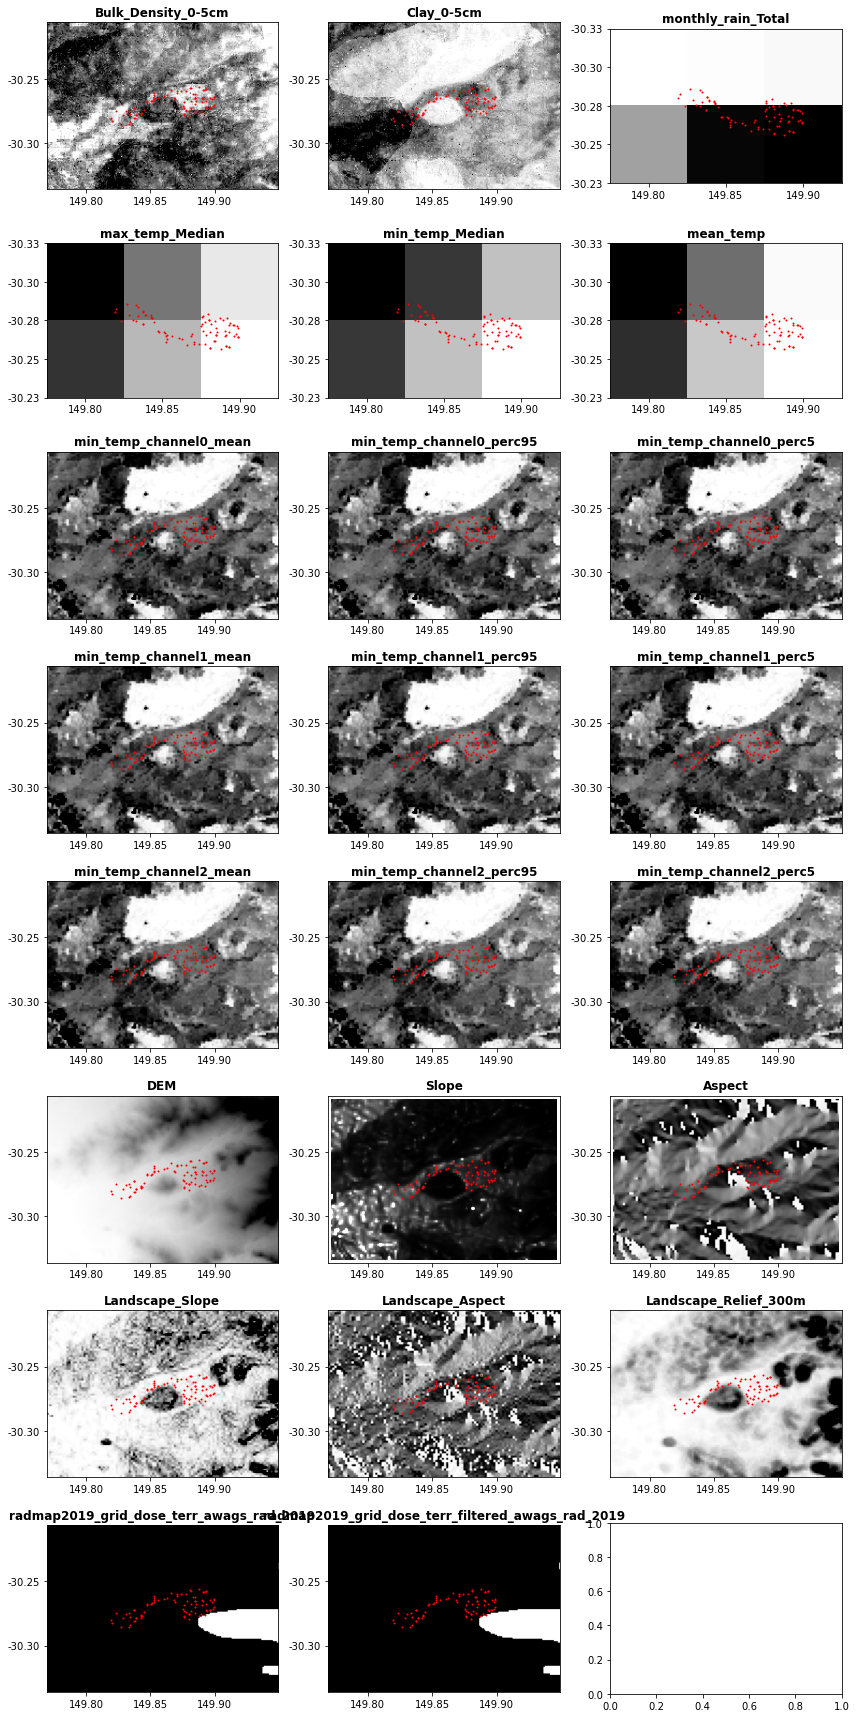

In [34]:
# Plot one of that datasets with the points on top
utils.plot_rasters(rasters,longs,lats,titles)

In [35]:
# print total time (only needed for testing if notebook kernel runs all at once):
print('FINISHED')
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

FINISHED
Duration: 0:34:37.200976
